# Learning from Audio

Starting point for signal processing, spectograms and other topics for dealing with audio data while building deep learning models where the data is audio.

This notebook is a compilation of Learning from Audio series by [@AdamSabra](https://theadamsabra.medium.com/) on Medium.com. GitHub repo for this can be found [here](https://github.com/theadamsabra/LearningfromAudio). 

In this notebook the data used is different from AdamSabra's work and the dataset can be found [here](https://www.kaggle.com/mayur1999/wavfiles-of-instruments-audio). The dataset is by [@MayurShah](https://www.kaggle.com/mayur1999) and its a collection of `.wav` audio files for different instruments.

### Table of contents

- Wave Forms
- Time Domain Features
- Fourier Transformations
- Spectrograms
- The Mel Scale, Mel Spectrograms, and Mel Frequency Cepstral Coefficients
- Pitch and Chromagrams

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display as lds

## Wave Forms

An introduction to wave forms and dealing with null data.

### Introduction

Audio is an extremely rich data source. Depending on the `sample rate` (the number of points sampled per second to quantify the signal), one second of data could contain thousands of points. Scale this up to hours of recorded audio, and you can see how Machine Learning and Data Science nicely intertwine with signal processing techniques.

This article aims to break down what exactly wave forms are as well as utilize `librosa` in Python for analysis and visualizations alongside `numpy` and `matplotlib`.

### Understanding Wave Forms

`Waves` are repeated `signals` that oscillate and vary in amplitude, depending on their complexity. In the real world, waves are `continuous` and `mechanical` which is quite different from computers being `discrete and digital`.

So, how do we translate something continuous and mechanical into something that is discrete and digital?

This is where the `sample rate` defined earlier comes in. Say, for example, the sample rate of the recorded audio is `100`. This means that for every recorded second of audio, the computer will place 100 points along the `signal` in attempts to best `trace` the continuous curve. Once all the points are in place, a smooth curve joins them all together for humans to be able to visualize the sound. Since the recorded audio is in terms of `amplitude` and `time`, we can intuitively say that the `wave form operates in the time domain`.

To better understand what something like this sounds like, we will look at three sounds: a kick drum, a guitar, and a snare drum.

Loading the `.wav` files using librosa. It will load the audio file in as a numpy array.

In [2]:
piano, sample_rate = librosa.load('../input/wavfiles-of-instruments-audio/10Piano.wav')
string, _ = librosa.load('../input/wavfiles-of-instruments-audio/10String.wav')
violin, _ = librosa.load('../input/wavfiles-of-instruments-audio/10Violins .wav')

The second value returned by the `load` method is the `sample rate` and since we haven't specified sample rate while loading, the default sample rate will be 22050 i.e. 22.05kHz.

Now that the data is loaded in, let’s visualize these sounds i.e. `wave forms`.

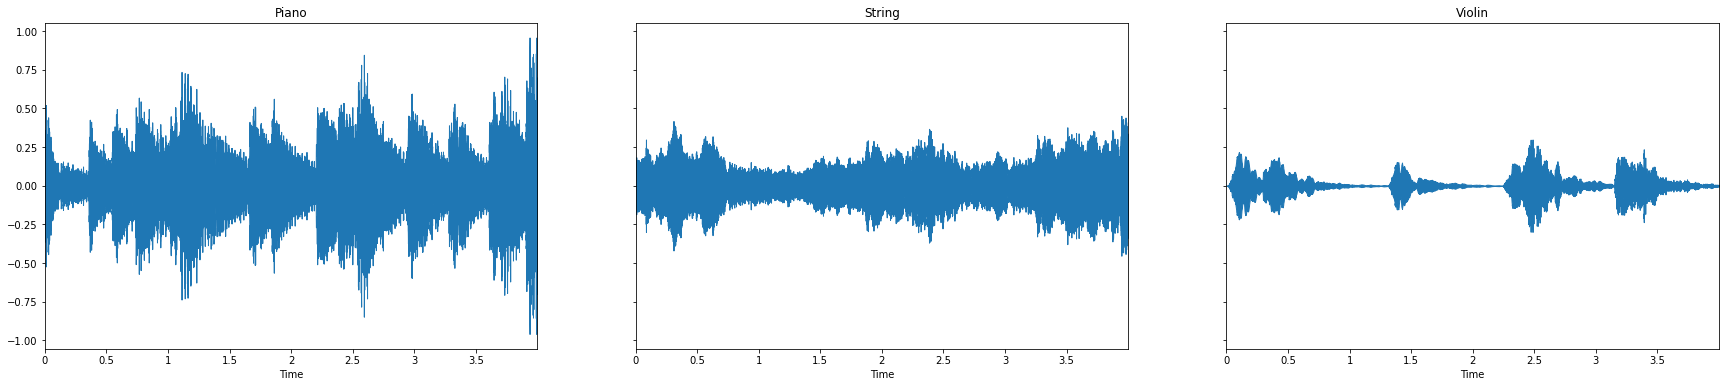

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(30, 6), sharey=True)

ax[0].set(title = 'Piano')
lds.waveplot(piano, sr=sample_rate, ax=ax[0])

ax[1].set(title = 'String')
lds.waveplot(string, sr=sample_rate, ax=ax[1])

ax[2].set(title = 'Violin')
lds.waveplot(violin, sr=sample_rate, ax=ax[2])

plt.show()

Loading the same audio with different `sample rates`.

In [4]:
file_path = '../input/wavfiles-of-instruments-audio/12Electric_Guitar.wav'

electric_guitar1, sr1 = librosa.load(file_path, sr=10000) # 10kHz
electric_guitar2, sr2 = librosa.load(file_path, sr=1000)  # 1kHz
electric_guitar3, sr3 = librosa.load(file_path, sr=100)   # 100Hz

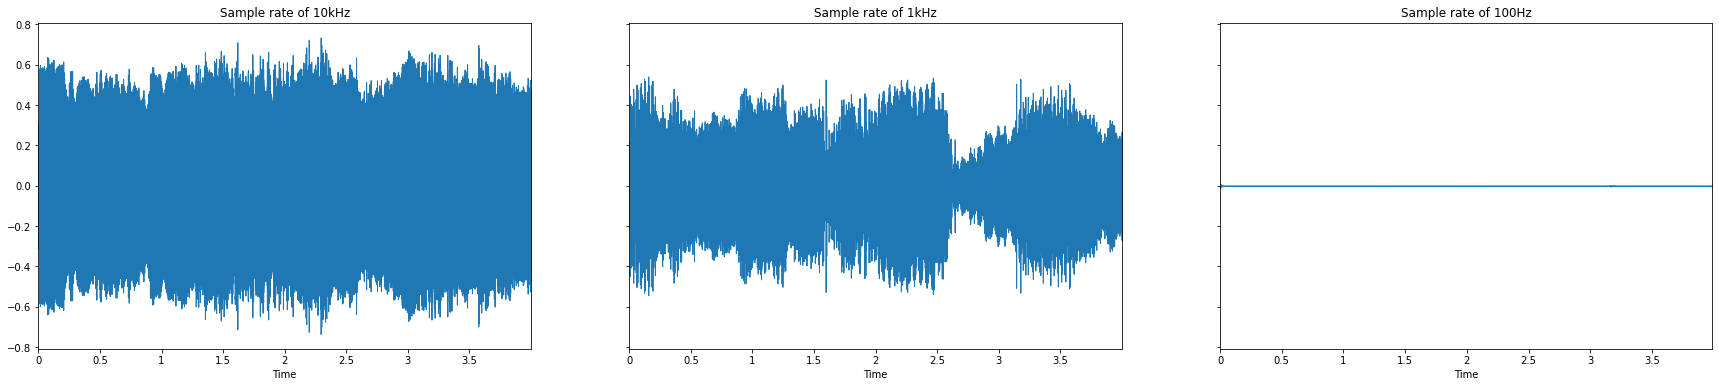

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(30, 6), sharey=True)

ax[0].set(title = 'Sample rate of 10kHz')
lds.waveplot(electric_guitar1, sr=sr1, ax=ax[0])

ax[1].set(title = 'Sample rate of 1kHz')
lds.waveplot(electric_guitar2, sr=sr2, ax=ax[1])

ax[2].set(title = 'Sample rate of 100Hz')
lds.waveplot(electric_guitar3, sr=sr3, ax=ax[2])

plt.show()

As we can see, not only does the resolution of the amplitudes diminish significantly, but also the length in which the entire song dwindles too.

If you see in visualization that they are not as distinct as we would like it to be like `audio signals` do not just `suddenly disappear`, they in fact `fade out` until it is impossible to perceive. This means that in terms of audio, this constitutes as `null data`.

### Null Data in Audio

There are many ways to treat null audio data in the `time domain`. However, the following approach often is the simplest. Given the signal and a minimum `threshold` for the `amplitude` of the signal:

- Take the `absolute value` of each point in the signal
- If the point is greater than the `threshold`, we keep it. Otherwise, we remove it.

In [6]:
# Create function for mask
def env_mask(wav, threshold):
    # Absolute value
    wav = np.abs(wav)
    
    # Point wise mask determination.
    mask = wav > threshold
    
    return mask

In [7]:
# Initialize mask
piano_mask = env_mask(piano, 0.1)
string_mask = env_mask(string, 0.1)
violin_mask = env_mask(violin, 0.1)

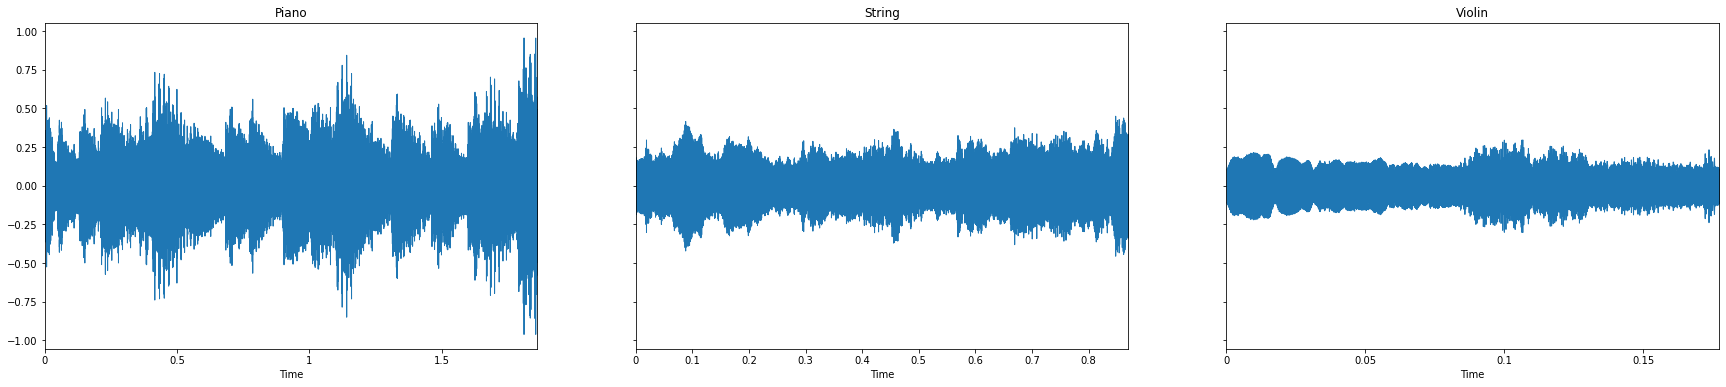

In [8]:
# Plotting the new signals

fig, ax = plt.subplots(1, 3, figsize=(30, 6), sharey=True)

# Visualize wave plots with mask applied.

ax[0].set(title = 'Piano')
lds.waveplot(piano[piano_mask], sr=sample_rate, ax=ax[0])

ax[1].set(title = 'String')
lds.waveplot(string[string_mask], sr=sample_rate, ax=ax[1])

ax[2].set(title = 'Violin')
lds.waveplot(violin[violin_mask], sr=sample_rate, ax=ax[2])

plt.show()

You can think of `thresholds` as a sort of parameter for the `recordings`. Different thresholds work differently for various sounds. Playing around with the threshold is a good way to see how and why this visualization changes.

Once the null data is beed removed from recordings (audio), it's much easier to see the personality in each sound like uniform shape, drowning out gradually with time, loud at beginning and drowns out with some remnants of sound remaining.

### Conclusion

This concludes the basics of dealing with audio signals in Python with `librosa`.

## Time Domain Features

Going deeper in time.

## Introduction

While Deep Learning often utilizes processes in the frequency domain, there are still many relevant features to be leveraged within the time domain that are relevant to many Machine Learning techniques. Simply put, these features can be extracted and analyzed to understand the wave form’s properties. When extracting features within the time-domain, we will generally study the amplitude of each sample. How we manipulate the amplitude gives us certain details about the signal in question.

Before beginning I would like to establish some notation:
    
- $s(k)$ refers to the Amplitude of the  $k^{th}$ sample.
- $K$  is the frame size, or the number of samples within each frame.
- $t$ represents the frame number.

Within these examples, I will elaborate on what the feature is, how to formally define it, and show how to extract the features in Python.

In [9]:
piano, sample_rate = librosa.load('../input/wavfiles-of-instruments-audio/10Piano.wav')
string, _ = librosa.load('../input/wavfiles-of-instruments-audio/10String.wav')
violin, _ = librosa.load('../input/wavfiles-of-instruments-audio/10Violins .wav')

### Amplitude Envelope

The `Amplitude Envelope (AE)` aims to extract the `maximum amplitude` within each frame and string them all together. It is important to remember that the amplitude represents the volume (or loudness) of the signal. First, we split up the signal into its constituent windows and find the maximum amplitude within each window. From there, we plot the maximum amplitude in each window along time.

We can use the AE for `onset detection`, or the detection of the beginning of a sound. In various speech processing applications this could be someone speaking or external noise, whereas in `Music Information Retrieval (MIR)` this could be the beginning of a note or instrument.

The main downfall of the AE is that is `not as robust to outliers` as `Root-Mean-Square Energy` which will we study soon.

Here is how we can formalize this concept:

$$\text{AE}_t = \max_{k = t \cdot K}^{(t+1) \cdot (K-1)} s(k) $$

Upon searching for a defined method in Python that could accomplish this task, I could not find it. Therefore, we will define it from scratch as it will be quite easy to do. The other feature extraction methods we will be looking at have already been defined in `librosa`, so we will be using those functions after formally defining them.

It is important to note that by the setup in this `for` loop, that we do not designate `hop length`. This means that when we create our upper and lower bounds, the windows do NOT overlap, making the `hop length` and the `frame length` the same.

In [10]:
def AE(signal, frame_length):
    '''
    Create the Amplitude Envelope of a given signal.
    
    Parameters:
    ------------
    - signal (numpy array):
        The signal/sound in question to be analyzed. 
    - frame_size (int):
        Number of samples within each frame. Formally defined as K.
    
    Returns:
    ---------
    Array of amplitude envelope
    '''
    
    AE = []
    
    # Calculate number of frames
    num_frames = math.floor(signal.shape[0] / frame_length)
    
    for t in range(num_frames):
        # Calculate bounds of each frame
        # By doing this, our hop length is the same as the frame length
        # Therefore, these frames are NOT overlapping.
        lower = t*frame_length
        upper = (t+1)*(frame_length-1)
        
        # Find maximum of each frame and add it to our array
        AE.append(np.max(signal[lower:upper]))
        
    return np.array(AE)

Now, to visualize and compare the AE among different instruments:

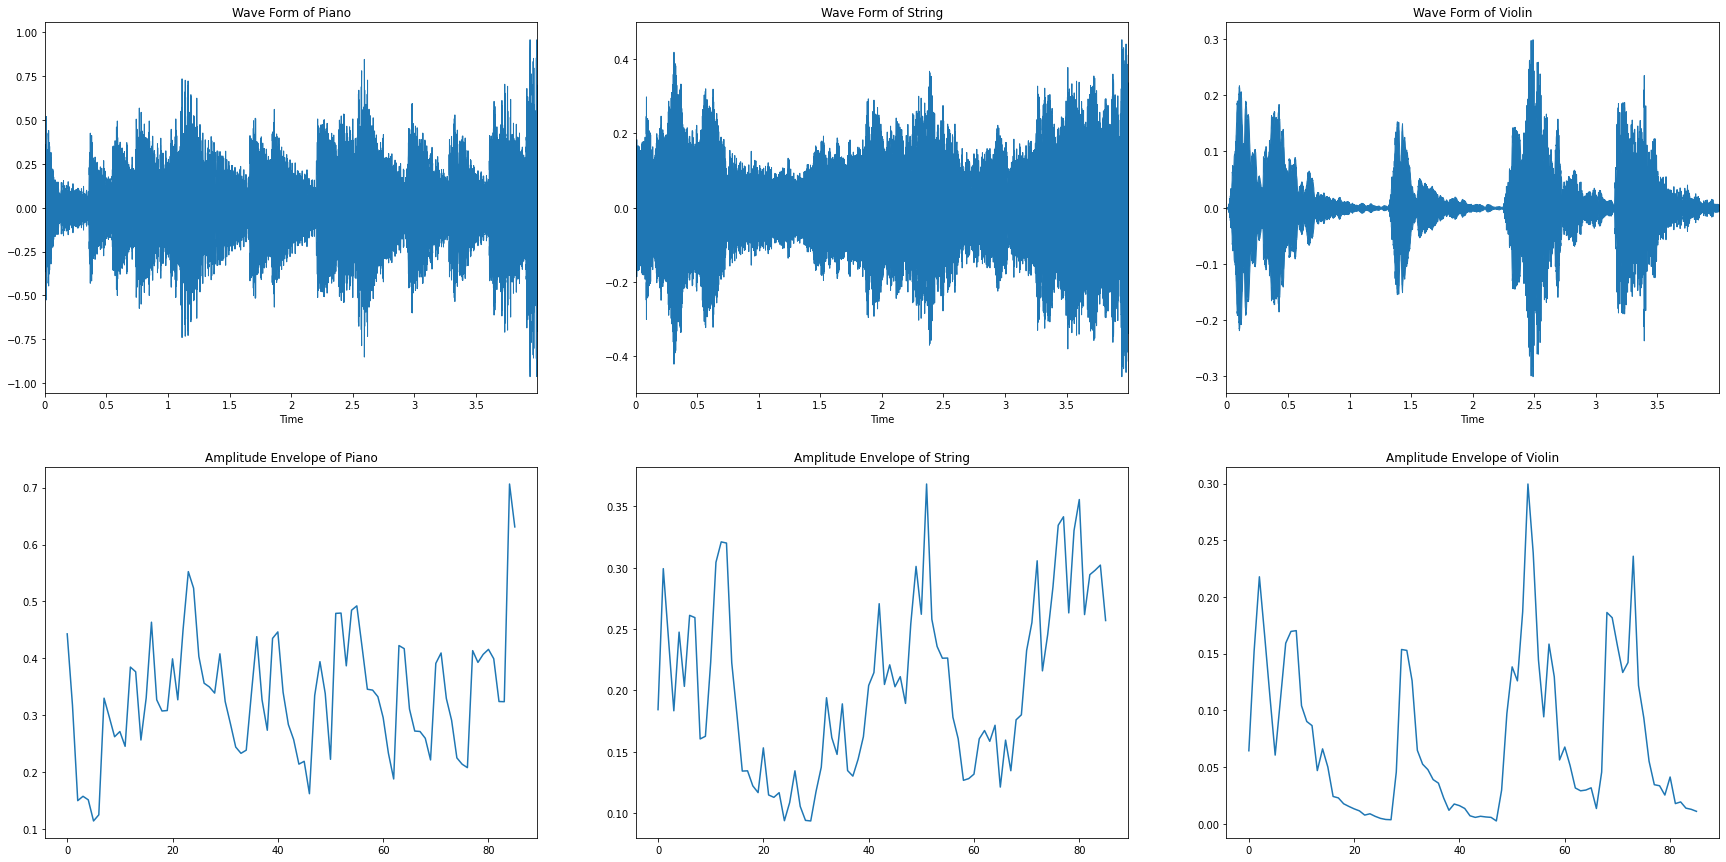

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(30, 15))

# Piano
ax[0,0].set(title='Wave Form of Piano')
lds.waveplot(piano, sr=sample_rate, ax=ax[0, 0])
ax[1,0].set(title = 'Amplitude Envelope of Piano')
ax[1,0].plot(AE(piano, 1024))

# String
ax[0,1].set(title='Wave Form of String')
lds.waveplot(string, sr=sample_rate, ax=ax[0, 1])
ax[1,1].set(title = 'Amplitude Envelope of String')
ax[1,1].plot(AE(string, 1024))

# Violin
ax[0,2].set(title='Wave Form of Violin')
lds.waveplot(violin, sr=sample_rate, ax=ax[0, 2])
ax[1,2].set(title = 'Amplitude Envelope of Violin')
ax[1,2].plot(AE(violin, 1024))

### Root-Mean-Square Energy

As mentioned previously, the Root-Mean-Square (RMS) Energy is quite similar to the AE. As opposed to onset detection, however, it attempts to perceive loudness, which can be used for event detection. Furthermore, it is much more robust against outliers, meaning if we segment audio, we can detect new events (such a a new instrument, someone speaking, etc.) much more reliably.

The formal definition of RMS Energy:
$$\text{RMS}_t = \sqrt{\frac{1}{K} \cdot \displaystyle\sum^{(t+1) \cdot (K-1)}_{k = t \cdot K} s(k)^2}$$

If you are familiar with the concept of the Root Mean Square, this will not be too new to you. However, if you are not, do not worry.

As we window across our wave form, we square the amplitudes within the window and sum them up. Once that is complete, we will divide by the frame length, take the square root, and that will be the RMS energy of that window.

To extract the RMS, we can simply use `librosa.feature.rms`. Now, we visualize it:

In [12]:
# Define RMS for each instrument
rms_piano = librosa.feature.rms(y=piano, frame_length=1024, hop_length=1024)
rms_string = librosa.feature.rms(y=string, frame_length=1024, hop_length=1024)
rms_violin = librosa.feature.rms(violin, frame_length=1024, hop_length=1024)

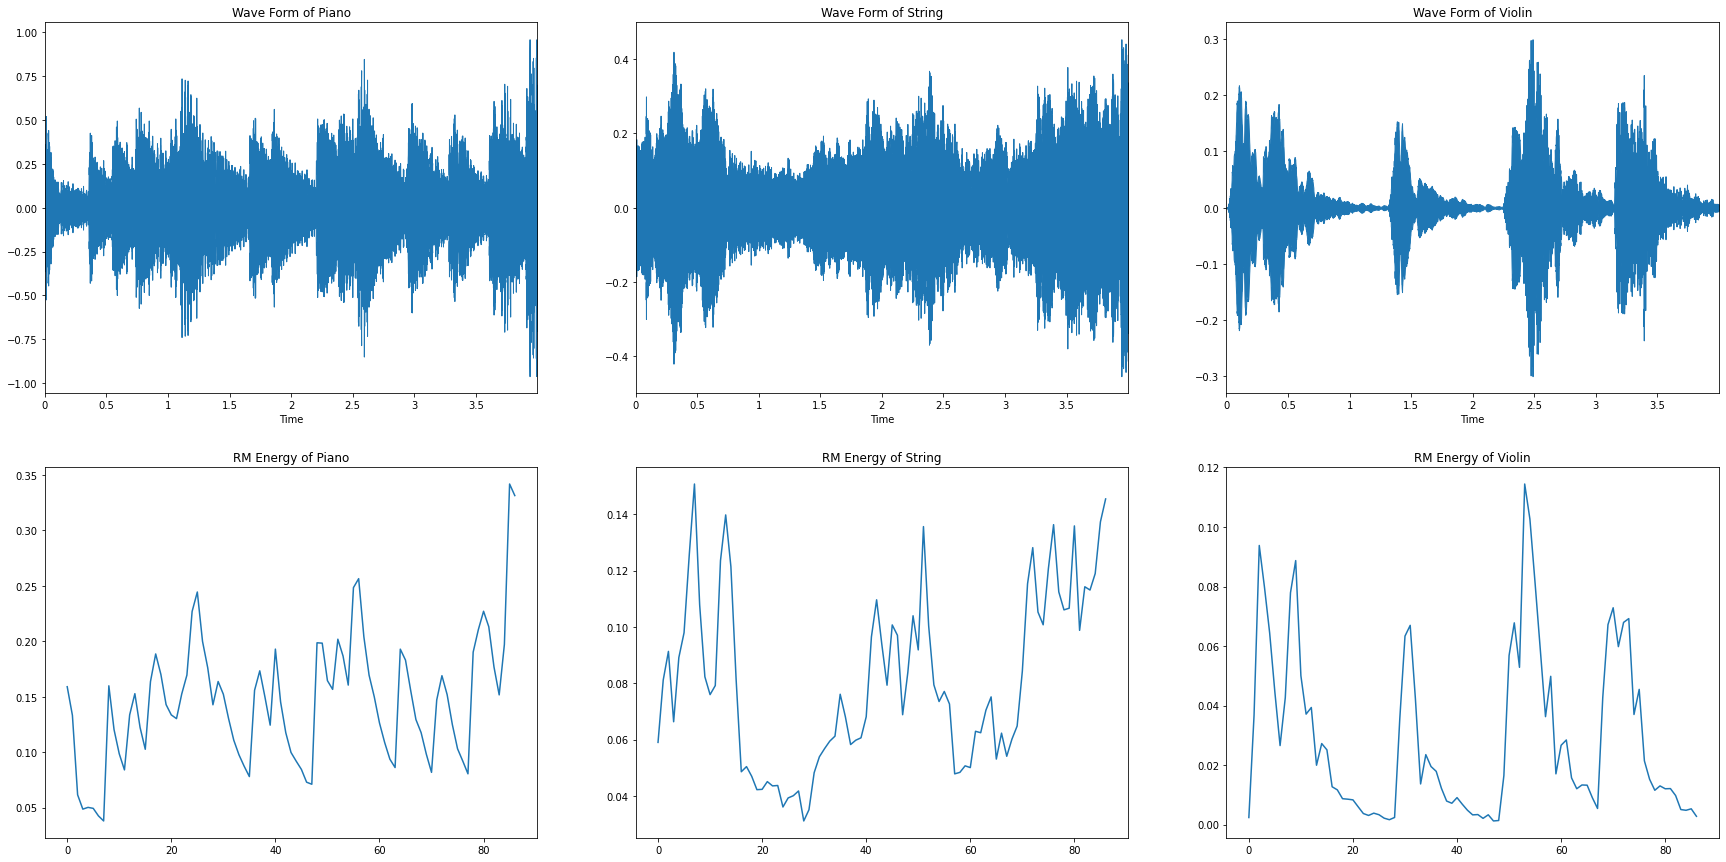

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(30, 15))

# Piano
ax[0,0].set(title='Wave Form of Piano')
lds.waveplot(piano, sr=sample_rate, ax=ax[0, 0])
ax[1,0].set(title = 'RM Energy of Piano')
ax[1,0].plot(rms_piano.T) # Returned shape is (1,t) so we take the transpose.

# String
ax[0,1].set(title='Wave Form of String')
lds.waveplot(string, sr=sample_rate, ax=ax[0, 1])
ax[1,1].set(title = 'RM Energy of String')
ax[1,1].plot(rms_string.T)

# Violin
ax[0,2].set(title='Wave Form of Violin')
lds.waveplot(violin, sr=sample_rate, ax=ax[0, 2])
ax[1,2].set(title = 'RM Energy of Violin')
ax[1,2].plot(rms_violin.T)

### Zero-Crossing Rate

The Zero-Crossing Rate (ZCR) aims to study the the rate in which a signal’s amplitude changes sign within each frame. Compared to the previous two features, this one is quite simple to extract.

The formal definition of ZCR is the following:
$$\text{ZCR}_t = \frac{1}{2} \cdot \displaystyle\sum^{(t+1) \cdot (K-1)}_{k = t \cdot K} \lvert \text{sgn}(s(k)) - \text{sgn}(s(k+1)) \rvert $$

For MIR, this feature is relevant for identifying percussion sound as they often have fluctuating signals that can ZCR can detect quite well as well as pitch detection. However, this feature is generally used as a feature in speech recognition for voice activity detection.

Using `librosa`, we can extract the ZCR using `librosa.feature.zero_crossing_rate`.

In [14]:
# Define RMS for each instrument
zcr_piano = librosa.feature.zero_crossing_rate(y=piano, frame_length=1024, hop_length=1024)
zcr_string = librosa.feature.zero_crossing_rate(y=string, frame_length=1024, hop_length=1024)
zcr_violin = librosa.feature.zero_crossing_rate(violin, frame_length=1024, hop_length=1024)

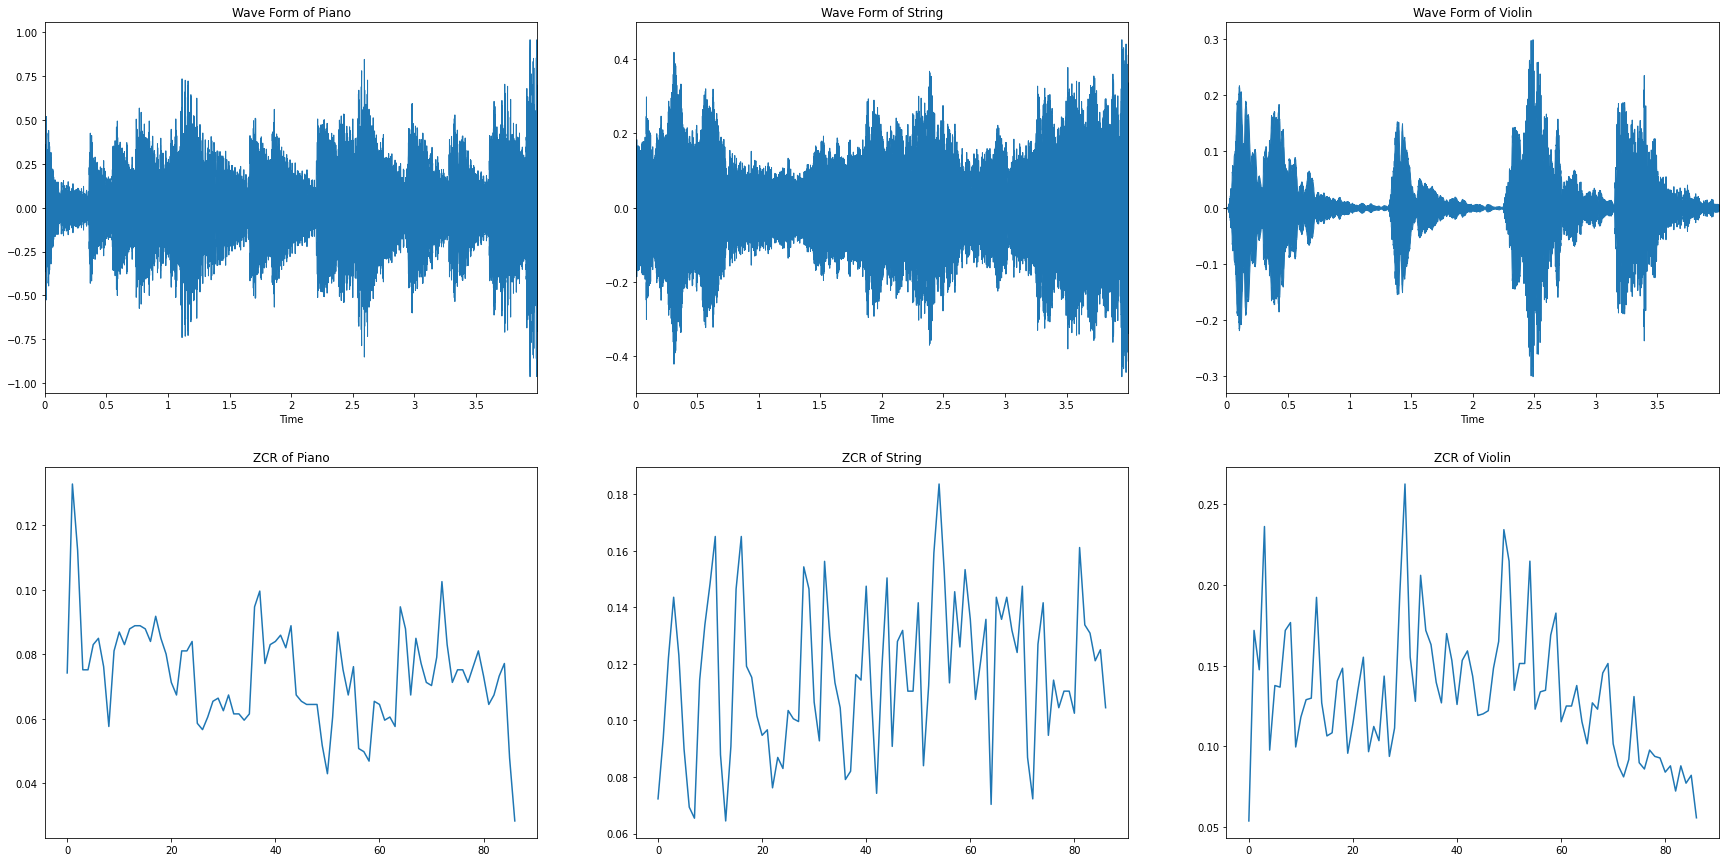

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(30, 15))

# Piano
ax[0,0].set(title='Wave Form of Piano')
lds.waveplot(piano, sr=sample_rate, ax=ax[0, 0])
ax[1,0].set(title = 'ZCR of Piano')
ax[1,0].plot(zcr_piano.T) # Returned shape is (1,t) so we take the transpose.

# String
ax[0,1].set(title='Wave Form of String')
lds.waveplot(string, sr=sample_rate, ax=ax[0, 1])
ax[1,1].set(title = 'ZCR of String')
ax[1,1].plot(zcr_string.T)

# Violin
ax[0,2].set(title='Wave Form of Violin')
lds.waveplot(violin, sr=sample_rate, ax=ax[0, 2])
ax[1,2].set(title = 'ZCR of Violin')
ax[1,2].plot(zcr_violin.T)

### Conclusion

By now, you should have an idea of how time feature extraction works, how it can be utilized in various audio based applications, and how to develop the feature extraction methods yourself. By leveraging the amplitude within specific windows, we open up numerous insights into various applications in MIR and ASR.

## Fourier Transformations

Breaking down a fundamental equation in signal processing

### Introduction

In Wave Forms, we looked at what waves are, how to visualize them, and how to deal with null data. In this article, I aim to develop an intuition on what the Fourier Transformation is, why it is useful when studying audio, show mathematical proofs to make it computationally efficient, and visualize the results.

In [16]:
piano, sample_rate = librosa.load('../input/wavfiles-of-instruments-audio/10Piano.wav')
string, _ = librosa.load('../input/wavfiles-of-instruments-audio/10String.wav')
violin, _ = librosa.load('../input/wavfiles-of-instruments-audio/10Violins .wav')

In [17]:
# Filter out dead noise
def trimmed(wav, threshold):
    # Absolute value
    wav = np.abs(wav)
    
    # Point wise boolean mask determination.
    mask = wav > threshold
    
    return wav[mask]

In [18]:
# Filter sounds
piano = trimmed(piano, 0.005)
string = trimmed(string, 0.005)
violin = trimmed(violin, 0.005)

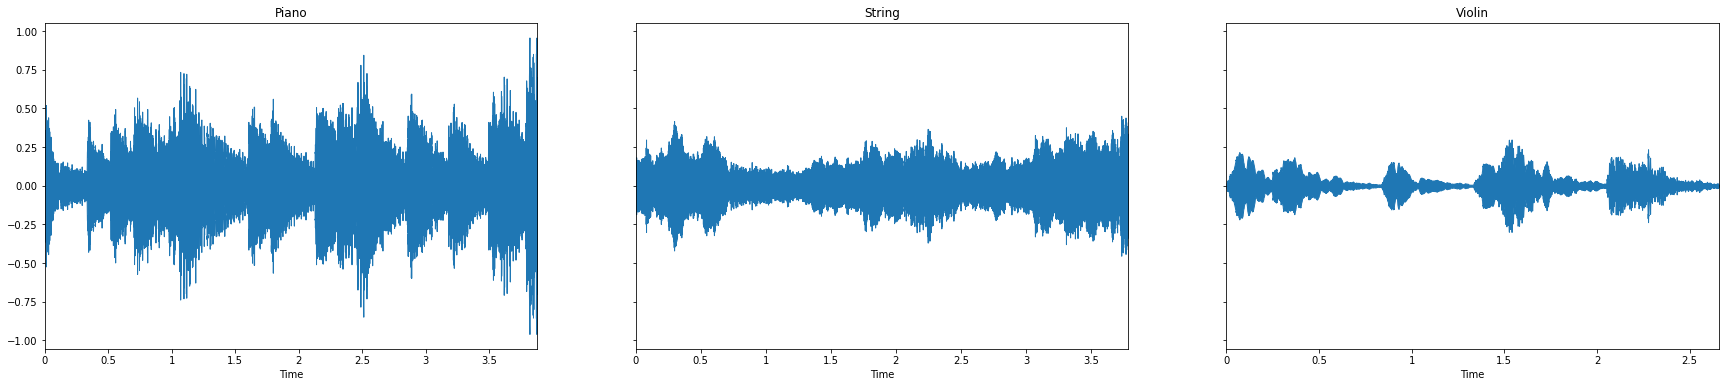

In [19]:
# Visualize wave forms

fig, ax = plt.subplots(1, 3, figsize=(30, 6), sharey=True)

ax[0].set(title = 'Piano')
lds.waveplot(piano, sr=sample_rate, ax=ax[0])

ax[1].set(title = 'String')
lds.waveplot(string, sr=sample_rate, ax=ax[1])

ax[2].set(title = 'Violin')
lds.waveplot(violin, sr=sample_rate, ax=ax[2])

plt.show()

### Fourier Transformation

#### What is the Fourier Transformation? Why is it Important?

When looking at the figure above, we can see various spikes of amplitudes creating a unique pattern to the unique sound. This is because all complex sounds — like the sounds of our voices — are really just a sum of many sine and cosine signals. The `gif` below presents a nice visualization of the objective:

![](https://miro.medium.com/max/525/1*uxQnCXu0qR1KeOOEZBq4-g.gif)

`By Lucas V. Barbosa — Own work, Public Domain`

It is important to note that by using this transformation, we will be translating the audio from the time-domain to the frequency-domain. Here are some key points about the two:

- The time domain looks at the variation of the signal’s amplitude over time. This is useful for understanding its physical shape. In order to plot this, we need time on the x-axis and amplitude on the y-axis. The shape gives us a good idea of how loud or quiet the sound will be.
- The frequency domain observes the constituent signals our recording is comprised of. By doing this, we can find a sort of “fingerprint” of the sound. In order to plot this, we need frequency on the x-axis and magnitude on the y-axis. The larger the magnitude, the more important that frequency is. The magnitude is simply the absolute value of our results from the FFT.

### Discrete Fourier Transformation (DFT)

The DFT, which is what `numpy` builds off of, is as follows:

$$ \hat x_k = \frac{1}{\sqrt{N}} \displaystyle\sum_{n=0}^{N-1} x_n \omega_{N}^{nk}  $$

where

$$ \omega_{N} = \exp \left(\frac{-2 \pi i}{N} \right) \\ k = 0, 1, \dots, (N - 1)$$

`Equations from Derek L. Smith, University of California, Santa Barbara.`

When learning about the `Fourier Transformation`, you may see a continuous version — which utilizes an integral as opposed to a sum — suitably called the `Continuous Fourier Transform`. The discrete version of the transformation is generally used for computers’ operations. In fact, even in the discrete form, most computers still lack the proper computational power to solve for the transformation as the raw equation below. The DFT has some nice properties that allow for computational ease, known as the `Fast Fourier Transformation`.

### Fast Fourier Transformation (FFT)

The FFT is as follows:

$$ \hat x_k = \frac{1}{\sqrt{N}} \displaystyle\sum_{n=0}^{m-1} x_{2n} \omega_{m}^{nk} + \frac{\omega_N}{\sqrt{N}} \displaystyle\sum_{n = 0}^{m-1}x_{2n+1} \omega_{m}^{nk}$$

`Equation from Derek L. Smith, University of California, Santa Barbara.`

Do not let the notation worry you. In the Discrete Fourier Transformation, you are dealing with a sum of products x, and omega. This equation splits sum of products into two — one along the odd indices and another along the even. This procedure above can be modeled much more efficiently with computer processes as opposed to the DFT.

Now, let’s visualize what the `FFT` looks like. In our application, we will be using the `numpy.fft.fft` function and apply it to our sound waves.

In [20]:
def fft_components(sound):
    # Find FFT
    fft = np.fft.fft(sound)
    
    # Find magnitude
    mag = np.abs(np.real(fft))
    
    # Find frequency
    freq = np.linspace(0, sample_rate, len(mag))
    
    return mag, freq

In [21]:
# Using function from above to find components
p_mag, p_freq = fft_components(piano)
s_mag, s_freq = fft_components(string)
v_mag, v_freq = fft_components(violin)

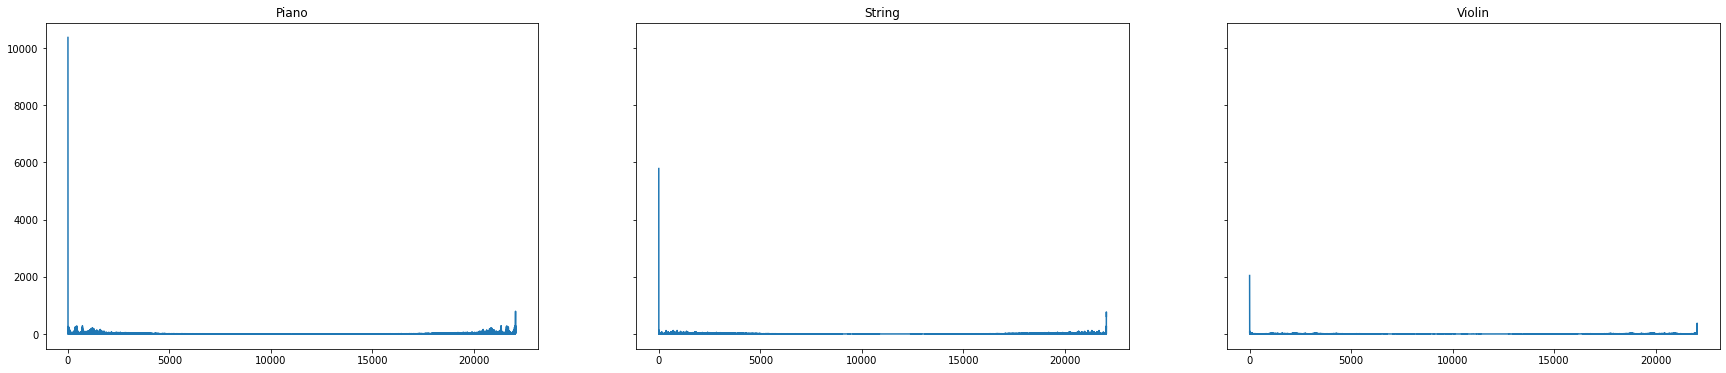

In [22]:
# Visualize the FFT

fig, ax = plt.subplots(1, 3, figsize=(30, 6), sharey=True)

ax[0].plot(p_freq, p_mag)
ax[0].set(title = 'Piano')

ax[1].plot(s_freq, s_mag)
ax[1].set(title = 'String')

ax[2].plot(v_freq, v_mag)
ax[2].set(title = 'Violin')

plt.show()

Again, there are some slight problems with the visualizations. However, this is a quite easy fix as the DFT has a symmetric property. This makes sense as our visualization on the left half mimics the visualizations on the right half. We will slice the arrays in half and visualize from there.

In [23]:
p_half = int(len(p_mag) / 2)
s_half = int(len(s_mag) / 2)
v_half = int(len(v_mag) / 2)

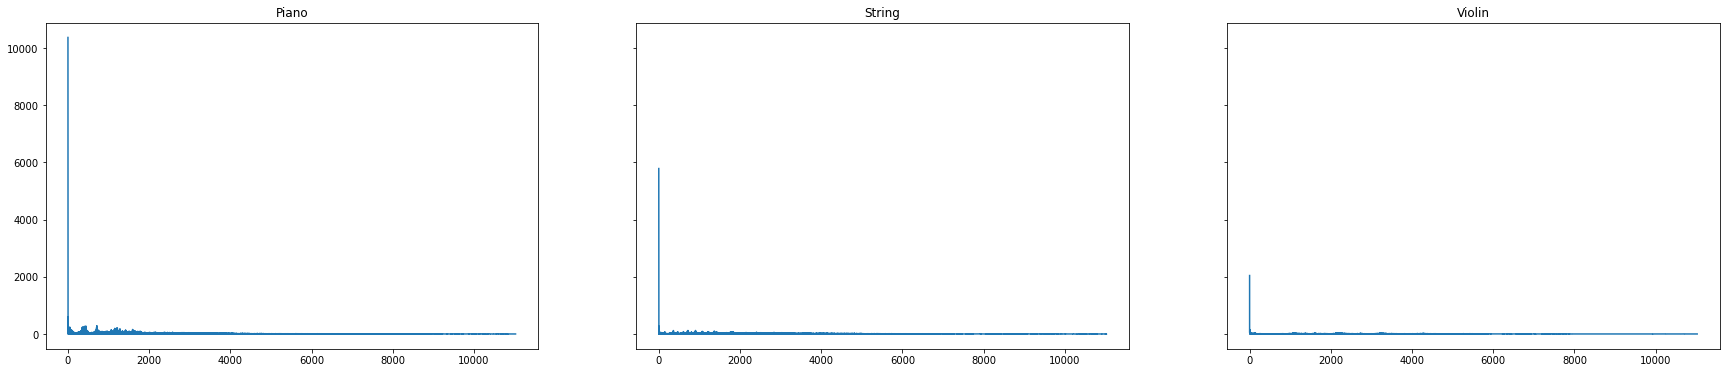

In [24]:
# Visualize the FFT

fig, ax = plt.subplots(1, 3, figsize=(30, 6), sharey=True)

ax[0].plot(p_freq[:p_half], p_mag[:p_half])
ax[0].set(title = 'Piano')

ax[1].plot(s_freq[:s_half], s_mag[:s_half])
ax[1].set(title = 'String')

ax[2].plot(v_freq[:v_half], v_mag[:v_half])
ax[2].set(title = 'Violin')

plt.show()

### Conclusion

In this article, you now should be able to extract the Fourier Transformation of any complex signal of any type and find its unique fingerprint.

## Spectrograms

Visualizing the structure of audio down to the millisecond.

### Introduction

When it comes to Machine Learning, or even Deep Learning, how the data is processed is fundamental to the model’s training and testing performance. When working in the domain of audio, there are a few steps to understand before getting to this stage, but once you get there, learning from audio becomes a quite easy task.

In this article I aim to break down what exactly a spectrogram is, how it is used in the field Machine Learning, and how you can use them for whatever problem you are attempting to solve.

### What is a Spectrogram?

You can think of spectrograms as pictures of audio. Kind of weird, I know, but you should strengthen this intuition as much as you can. The spec portion in spectrogram comes from `spectrum` and the color-bar you see on the right of the figure is just that. What is the spectrum of? The frequencies in which the audio has.

With all of this information in mind, let me formalize the definition.

> A spectrogram is a figure which represents the spectrum of frequencies of a recorded audio over time.

This means that as we get brighter in color in the figure, the sound is heavily concentrated around those specific frequencies, and as we get darker in color, the sound is close to empty/dead sound. This allows us to get a good understanding of the shape and structure of the audio without even listening to it! This is where the power of spectrograms come into play for various ML/DL models.

### How to Create Spectrograms

Now a question arises, how do we calculate the spectrograms? The answer to this question is much simpler than expected.

- Split the audio into overlapping chunks, or windows.
- Perform the `Short Time Fourier Transformation` on each window. Remember to take its absolute value!
- Each resulting window has a vertical line representing the magnitude vs frequency.
- Take the resulting window and convert to decibels. This gives us a rich image of the sound’s structure.
- Finally, we lay out these windows back into the length of the original song and display the output.

Now that we have a decent understanding of what spectrograms are exactly, let’s learn how to retrieve them from sounds in Python! Using functions in `librosa`, we can have this be done for us with little to no effort.

In [25]:
piano, sample_rate = librosa.load('../input/wavfiles-of-instruments-audio/10Piano.wav')
string, _ = librosa.load('../input/wavfiles-of-instruments-audio/10String.wav')
violin, _ = librosa.load('../input/wavfiles-of-instruments-audio/10Violins .wav')

Second, I am going to define two functions; one that will perform all the necessary steps and output the processed signal, and another that will plot the spectrogram. Make sure to read through the comments and lines to understand the process in which this is done.

In [26]:
def to_decibles(signal):
    # Perform Short Time Fourier Transformation of signal and take absolute value of results
    stft = np.abs(librosa.stft(signal))
    
    # Convert to dB (db - Decibel, to measure the sound, if larger db then lound or the other way round)
    D = librosa.amplitude_to_db(stft, ref=np.max) # Set reference value to the maximum value of stft.
    
    return D # Return converted audio signal

In [27]:
# Function to plot the converted audio signal
def plot_spec(D, sr, instrument):
    fig, ax = plt.subplots(figsize = (30, 5))
    spec = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear', ax=ax)
    ax.set(title = 'Spectrogram of ' + instrument)
    fig.colorbar(spec)

Now, with our functions defined, we can simply use `plot_spec` to graph the results!

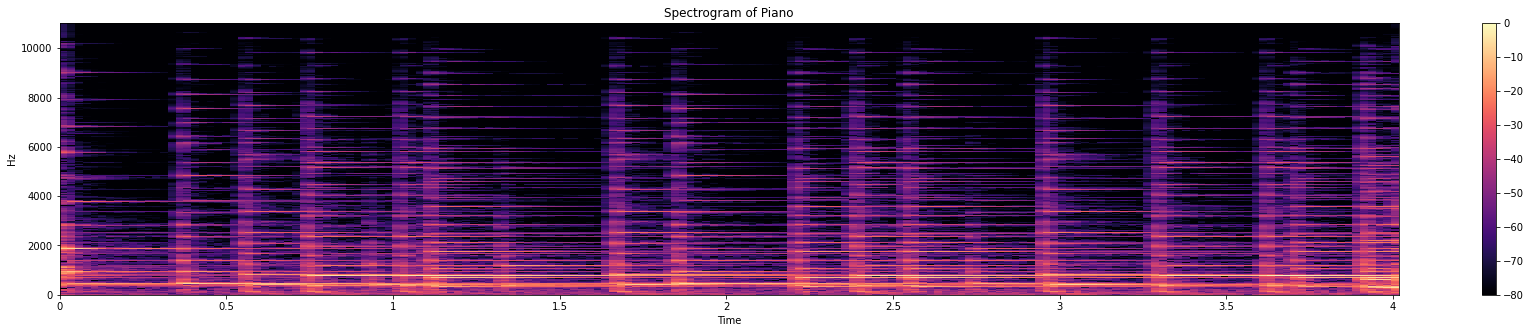

In [28]:
plot_spec(to_decibles(piano), sample_rate, 'Piano')

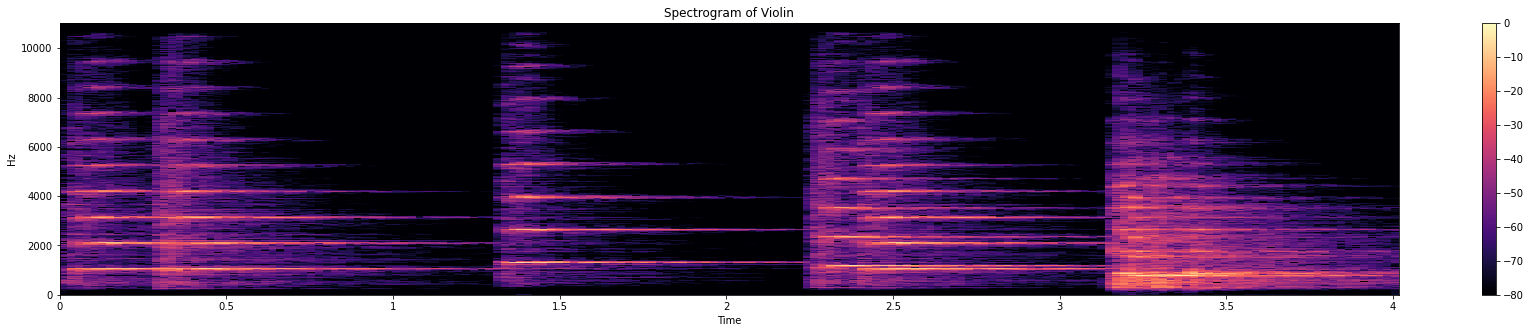

In [29]:
plot_spec(to_decibles(violin), sample_rate, 'Violin')

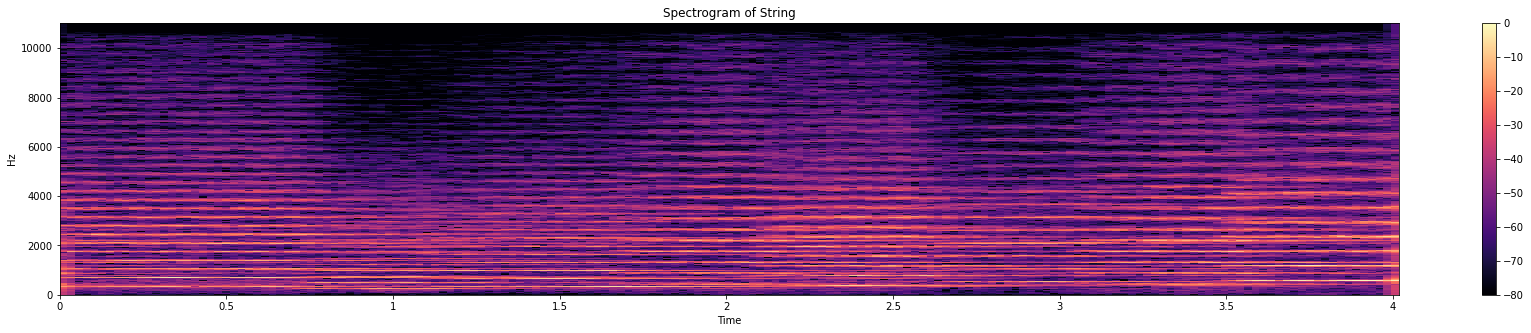

In [30]:
plot_spec(to_decibles(string), sample_rate, 'String')

### Conclusion

By now, you should be able to understand how spectrograms are created using the Short Time Fourier Transformation, as well as how to create them in Python. These representations of audio allow for various Deep Learning architectures to extract features much easier than wave form and even Fourier representations.

## The Mel Scale, Mel Spectrograms, and Mel Frequency Cepstral Coefficients

Breaking down the intuition for human-like audio representations

By now, we have developed a stronger intuition as to what spectrograms are, and how to create them. Simply put, spectrograms allow us to visualize audio and the pressure these sound waves create, thus allowing us to see the shape and form of the recorded sound.

The main aim of this article is to introduce a new flavor of spectrograms — one that is widely used in the Machine Learning space as it represents `human-like perception` very well.

### Mel Scale

Before discussing `Mel Spectrograms`, we first need to understand what the Mel Scale is and why it is useful. The Mel Scale is a `logarithmic transformation` of a signal’s frequency. The core idea of this transformation is that sounds of equal distance on the Mel Scale are perceived to be of `equal distance` to humans. What does this mean?

For example, most human beings can easily tell the difference between a 100Hz and 200Hz sound. However, by that same token, we should assume that we can tell the difference between 1000Hz and 1100Hz, right? Wrong.

It is actually much harder for humans to be able to differentiate between higher frequencies, and easier for lower frequencies. So, even though the distance between the two sets of sounds are the same, our perception of the distance is not. This is what makes the Mel Scale fundamental in Machine Learning applications to audio, as it mimics our own perception of sound.

The transformation from the Hertz scale to the Mel Scale is the following:

$$m = 1127 \cdot \log \left(1 + \frac{f}{700} \right) $$

Note that `log` in this case refers to the natural logarithm (also denoted as ln.) If the logarithm were of base 10, the equation’s coefficient (1127) would alter slightly. However, in this article, we will simply refer to the equation stated above.

Let’s visualize the relationship between `Hertz` and `Mels`:

In [31]:
# Create function to convert Hz to Mels
def freqToMel(f):
    return 1127 * math.log(1 + (f/700))

In [32]:
# Vectorize function to apply to numpy arrays
freqToMelv = np.vectorize(freqToMel)

In [33]:
# Observing 0 to 10,000 Hz
Hz = np.linspace(0, 1e4) 

# Now we just apply the vectorized function to the Hz variable
Mel = freqToMelv(Hz) 

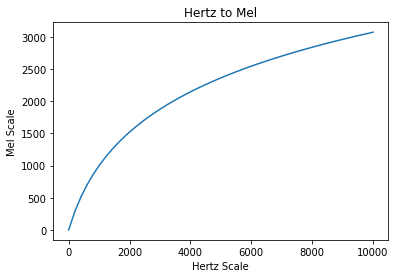

In [34]:
# Plotting the figure:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(Hz, Mel)
plt.title('Hertz to Mel')
plt.xlabel('Hertz Scale')
plt.ylabel('Mel Scale')
plt.show()

As we can see from the graph above, frequencies that are lower in Hz have a larger distance between them Mels, whereas frequencies that are higher in Hz have a smaller distance between them in Mels, reinforcing its human-like properties.

Now that we have a good understanding of the Mel Scale’s utility, let’s use this intuition to develop Mel Spectrograms.

### Mel Spectrograms

Mel Spectrograms are spectrograms that visualize sounds on the Mel scale as opposed to the `frequency domain`, as we saw previously. Now, I know what you are thinking, is it really that simple? Yes, it is.

As soon as the intuition of spectrograms are established, it makes learning various flavors of them very easy. All that is required is the new framework in which we develop our spectrograms under. I will assume that you know the underlying properties of how this is done. Developing Mel Spectrograms are even easier than their definition.

In [35]:
# Using env_mask
def env_mask(wav, threshold):
    # Absolute value
    wav = np.abs(wav)
    
    # Point wise mask determination.
    mask = wav > threshold
    
    return wav[mask]

This function creates a mask to develop an envelope that trims out unnecessary dead noise. This allows us to focus on the significant portions of the audio.

In [36]:
piano, sample_rate = librosa.load('../input/wavfiles-of-instruments-audio/10Piano.wav')
string, _ = librosa.load('../input/wavfiles-of-instruments-audio/10String.wav')
violin, _ = librosa.load('../input/wavfiles-of-instruments-audio/10Violins .wav')

In [37]:
# Mask audio to trim out dead noise (simple data cleaning)
piano = env_mask(piano, 0.005)
string = env_mask(string, 0.005)
violin = env_mask(violin, 0.005)

In [38]:
# Create Mel Spectrograms of sounds
piano_spec = librosa.feature.melspectrogram(piano)
string_spec = librosa.feature.melspectrogram(string)
violin_spec = librosa.feature.melspectrogram(violin)

In [39]:
# Convert amplitudes to dB
p = librosa.amplitude_to_db(piano_spec)
s = librosa.amplitude_to_db(string_spec)
v = librosa.amplitude_to_db(violin_spec)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  del sys.path[0]


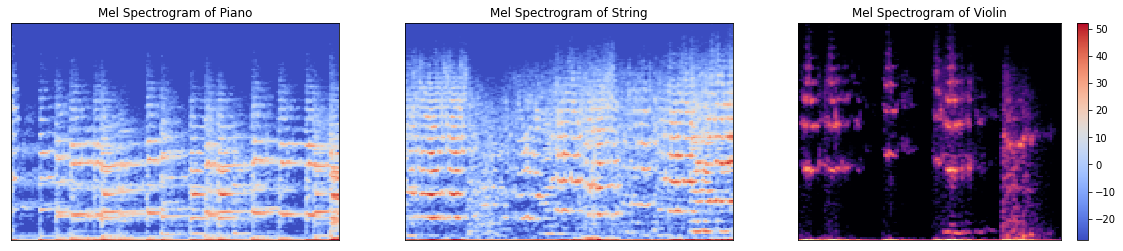

In [40]:
# Plot mel spectrograms
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

ax[0].set(title='Mel Spectrogram of Piano')
i = librosa.display.specshow(p, ax=ax[0])

ax[1].set(title='Mel Spectrogram of String')
librosa.display.specshow(s, ax=ax[1])

ax[2].set(title='Mel Spectrogram of Violin')
librosa.display.specshow(v, ax=ax[2])

plt.colorbar(i)

Similar to our results in spectrograms, we can see how each sound takes a unique shape based off of the sound it actually produces.

### Mel Frequency Cepstral Coefficients

`Mel Frequency Cepstral Coefficients (MFCCs)` were originally used in various speech processing techniques, however, as the field of `Music Information Retrieval (MIR)` began to develop further adjunct to Machine Learning, it was found that MFCCs could represent timbre quite well.

The basic procedure to develop MFCCs is the following:
- Convert from Hertz to Mel Scale
- Take logarithm of Mel representation of audio
- Take logarithmic magnitude and use Discrete Cosine Transformation
- This result creates a spectrum over Mel frequencies as opposed to time, thus creating MFCCs

If the ML problem warrants MFCCs to be used, such as automatic speech recognition or denoising audio, the number of coefficients used is a hyperparameter of the model. Because of this, the number of MFCCs will vary based on the problem. However, for this example, we will use `librosa’s` default 20 MFCCs. In `librosa`, we can do all of this and visualize the output in a just few lines of code:

In [41]:
# Take MFCCs of sounds:
p_mfcc = librosa.feature.mfcc(piano)
s_mfcc = librosa.feature.mfcc(string)
v_mfcc = librosa.feature.mfcc(violin)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  del sys.path[0]


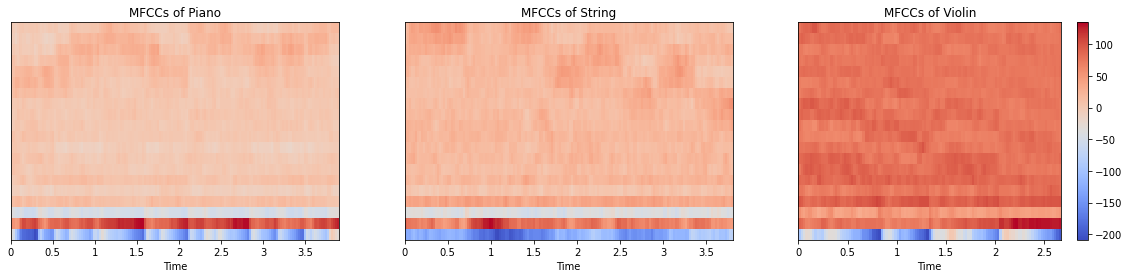

In [42]:
# Plot MFCCs
fig, ax = plt.subplots(1,3, figsize = (20, 4))

ax[0].set(title='MFCCs of Piano')
i = librosa.display.specshow(p_mfcc, x_axis='time', ax=ax[0])

ax[1].set(title='MFCCs of String')
librosa.display.specshow(s_mfcc, x_axis='time', ax=ax[1])

ax[2].set(title='MFCCs of Violin')
librosa.display.specshow(v_mfcc, x_axis='time', ax=ax[2])

plt.colorbar(i)

### Conclusion

As a wrap-up for this article, you have now learned:
- What the Mel Scale is and how it plays a role in human-like interpretation of audio
- How to map the Mel Scale onto spectrograms
- What MFCCs are, certain use cases of MFCCs, and how to develop them

Leveraging Mel Spectrograms is a fantastic way to process audio such that various Deep Learning and Machine Learning problems can learn from the recorded sounds.

## Pitch and Chromagrams

Interpreting pitch changes for Music Information Retrieval

### Introduction

Now that the idea of a spectrogram is fully understood, we want to delve deeper into various structures beyond the frequency over time. When studying the sound waves over the Mel Scale, we got a taste of this — especially with the MFCCs. While visualizing MFCCs are technically not spectrograms, the rough idea still holds.

This article will be a bit more focused towards Music Information Retrieval (MIR) however, in that we are going to study the changes in pitch over time. To do this, we are going to need to understand what pitch is, how it is notated, and how we can use the Fourier Transformation to determine the changes in pitch.

### What is Pitch?

Pitch can be understood as a relative highness/lowness of a sound. The higher the sound, the higher the pitch and the lower the sound, the lower the pitch. Simple enough, right? To fully understand pitch, we need to understand the pitch classes and octaves.

Pitch classes are the letters that are associated with each sound. All pitches fall under one of the 7 letters: A, B, C, D, E, F, and G. Let’s assume we were playing the piano and we started at A. We would keep going up one white key until we hit the key G. As we ascend with each white key, we inevitably cycle through the letters over and over. However, when we hit the second A key after the G, it is important to note that it is not the same sound we started at originally. The pitch class is the same; it is the A key. However the sound is higher than before, indicating we are in the next (higher) octave.

Before diving into octaves, let’s quickly cover the black keys. If we start at C and go up one black key, we hit what’s called C# (pronounced C sharp.) If we look at the figure once more, we also see that it is also called D♭(pronounced D flat.) This is because the black key is also before D. Simply put, if we go up one black key, the note is “sharped” and if we go down one black key, then the note is “flattened.” In terms of what humans hear, they are equivalent, so we would call these notes enharmonic. As for the case for when there is no black key between two white keys, you do not have to worry about that for this article as that involves more music theory than what is necessary.

An octave is the number specifying which group of pitches we are in. If we repeated our example knowing we were in A3, the next A key we hit is A4. Again, this should not be too hard to wrap your head around. The middle key of the keyboard is C4 and it is generally used as a reference for which octave you are in.
It is important to note that the number does not increase after every A value, but rather after every C value. This means that if we were to start at the middle C, or C4, the B key behind it is B3 and the B key after it is B4.

### About Chromagrams

Now that we understand pitch in Music, we can dive into chroma filters which acts as the basis of our chromagrams.

The Chroma filters can be derived from the Chroma filter bank. The filter bank aims to project all the energy of the recorded sound into 12 bins i.e. all the notes we saw, plus the minor/major keys (which is also the black keys of the piano) irrespective of the octave it is in. By disregarding octave, we can then create a heat-map of how the pitch changes over time, which is an important aspect of MIR. For example, should you decide to teach an LSTM how to play music, these features would be very useful as they would tell the neural network how the pitch would likely change over time.

Let’s visualize the Chroma filter bank across various frequencies.

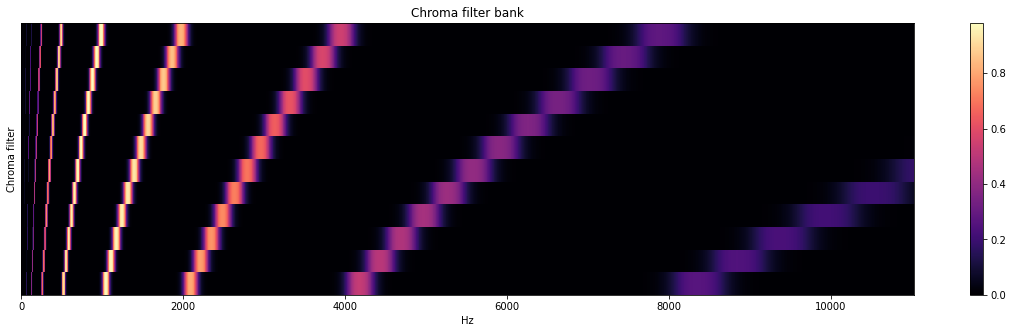

In [43]:
# From https://librosa.org/doc/latest/generated/librosa.filters.chroma.html#librosa.filters.chroma

chromafb = librosa.filters.chroma(22050, 4096)
fig, ax = plt.subplots(figsize=(20, 5))
img = librosa.display.specshow(chromafb, x_axis='linear', ax=ax)
ax.set(ylabel='Chroma filter', title='Chroma filter bank')
fig.colorbar(img, ax=ax)

By taking the dot product of our Fourier based spectrogram (by taking the STFT) and this filter bank, we can then map the songs in question onto the set of pitches we discussed prior. Luckily, thanks to librosa the function to create the chromagram has been created for us already. Note that we do not have to use the STFT on the audio as our basis, but that is outside the scope of this article.

In [44]:
piano, sample_rate = librosa.load('../input/wavfiles-of-instruments-audio/10Piano.wav')
string, _ = librosa.load('../input/wavfiles-of-instruments-audio/10String.wav')
violin, _ = librosa.load('../input/wavfiles-of-instruments-audio/10Violins .wav')

In [45]:
# Create chromagrams
piano_chroma = librosa.feature.chroma_stft(piano, sr=sample_rate)
string_chroma = librosa.feature.chroma_stft(string, sr=sample_rate)
violin_chroma = librosa.feature.chroma_stft(violin, sr=sample_rate)

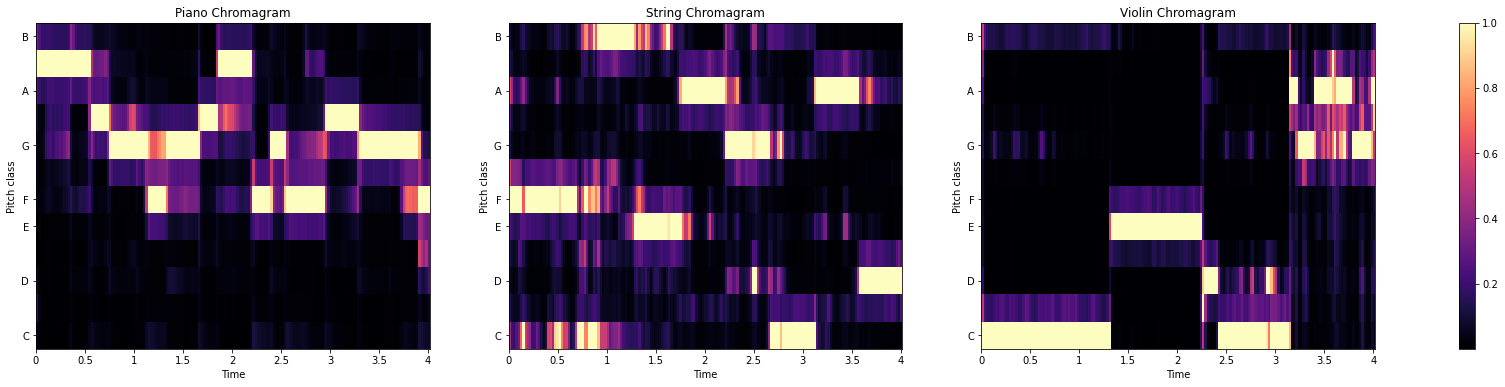

In [46]:
# Visualize the STFT chromagrams
fig, ax = plt.subplots(1,3, figsize=(30, 6))

img = librosa.display.specshow(piano_chroma, y_axis='chroma', x_axis='time', ax=ax[0])
ax[0].set(title = 'Piano Chromagram')

librosa.display.specshow(string_chroma, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(title = 'String Chromagram')

librosa.display.specshow(violin_chroma, y_axis='chroma', x_axis='time', ax=ax[2])
ax[2].set(title = 'Violin Chromagram')

fig.colorbar(img, ax=ax)
plt.show()

We can see how the pitch changes over time.

### Conclusion

By now, you should have a good understanding of what pitch is, how we classify each pitch, what the chroma filter aims to do, and how we visualize chromagrams.

---